<a href="https://colab.research.google.com/github/tatsuhiko-ikeda3/GAN_with_VIT/blob/main/segan_75epoch_flower_D_se_G_c_FID_KID_devide_1_color_relativistic1_hinge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#パッケージのダウンロード


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import argparse

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
import torchvision.transforms as transforms

In [6]:
import torchvision.datasets as dset

In [7]:
import torchvision.utils as vutils

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [9]:
import glob

In [10]:
from torch.utils.data import Dataset
from PIL import Image

In [11]:
from torch.utils.data import DataLoader
import torchvision

In [12]:
!pip install torchmetrics
!pip install torchmetrics[image]

!pip install torch-fidelity

from torchmetrics.image.inception import InceptionScore


import torchmetrics
import torch_fidelity

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance
fid = FrechetInceptionDistance(feature=2048)

from torchmetrics.image.kid import KernelInceptionDistance


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 30.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth


  0%|          | 0.00/91.2M [00:00<?, ?B/s]

In [13]:
kid = KernelInceptionDistance(subset_size=15)

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `Kernel Inception Distance` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [14]:
#ハイパーパラメータの設定

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=75)
parser.add_argument("--batch_size", type = int, default=32)
parser.add_argument("--lr_g", type = float, default=2e-4)
parser.add_argument("--lr_d", type = float, default=3e-4)
parser.add_argument("--nch_g", type = int, default=64)
parser.add_argument("--nch_d", type = int, default=64)
parser.add_argument("--z_dim", type = int, default=100)
parser.add_argument("--beta1", type = float, default=0.5)

opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=32, beta1=0.5, lr_d=0.0003, lr_g=0.0002, n_epoch=75, nch_d=64, nch_g=64, z_dim=100)


In [16]:
class ImageDataset(Dataset):
    def __init__(self,  transform = None):
        super().__init__()
        self.file_list = glob.glob("/content/drive/MyDrive/102flowers (2)/jpg/*.jpg")#/content/drive/MyDrive/img_align_celeba.zip
        #self.file_list = glob.glob("/content/drive/MyDrive/cityscapes/cityscapes_data/train/*.jpg" )#/content/drive/MyDrive/cityscapes/cityscapes_data/train
        #self.file_list = glob.glob("/content/drive/MyDrive/Test/**/*.jpg" )#fruits
       # self.file_list = glob.glob("/content/drive/MyDrive/img_align_celeba.zip/jpg/*.jpg")#C:\Users\ikeda\Downloads\img_align_celeba\img_align_celeba
        #self.file_list = glob.glob("/content/drive/MyDrive/–¢Šm”F 758452(1).crdownload/*.jpg")
        self.transform = transform

    
    def __getitem__(self, index):
        if self.transform is not None:
            img = self.transform(Image.open(self.file_list[index]))
        else:
            img = Image.open(self.file_list[index])
        return img
    
    def __len__(self):
        return len(self.file_list)

In [17]:
from torchvision.transforms.transforms import CenterCrop

transform = transforms.Compose([
    
    transforms.Resize(80),
    transforms.CenterCrop(64),
    transforms.ToTensor(), 
                               transforms.Normalize((0.5,),(0.5,))])

In [18]:
#dataset = dset.MNIST("./", train = True, download = True,transform = transform)
dataset = ImageDataset(transform = transform)
#dataset = torchvision.datasets.CelebA("./", split = "test", download = True,transform = transform) #Cityscapes
#dataset = torchvision.datasets.Cityscapes("C:\Users\ikeda\Downloads\cityscapes\cityscapes_data\cityscapes_data", split='train', mode='fine', target_type='color')


In [19]:
dataloader = DataLoader(dataset = dataset, batch_size = opt.batch_size,num_workers = 2,  shuffle = True)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

In [21]:
#モデルの設定

In [22]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [23]:
class ResidualBlock_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        out_channels = in_channels
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.se_block_0 = SE_G(out_channels)
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.conv1(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.se_block_0(x)
        x = self.bn(x)
        x = x + self.shortcut(identity)
        return x   

In [24]:
class ResidualBlock_1(nn.Module):#実質パディングとスペクトラム正規化とインスタンス正規化
  def __init__(self, in_channels):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        nn.ReLU(inplace = True),
        
        nn.ReflectionPad2d(1),
        nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, 3)),
        nn.InstanceNorm2d(in_channels),
        
    )
  def forward(self, x):
    out = self.conv_layers(x)
    out = out + x
    return out

In [25]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
        #out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [26]:
#import torch
#from layers.transformer.ScaledDotProductAttention import ScaledDotProductAttention
#from torch import nn


class MultiHeadAttention(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.Conv2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.Conv2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        self.q = self.se_block_0(self.q)
        self.k = self.se_block_0(self.k)
        self.v = self.se_block_0(self.v)

        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out


In [27]:

class MultiHeadAttention_G(nn.Module):
    def __init__(self, in_channels, h = 8):
        super().__init__()  
        d_model = in_channels
        self.d_model = in_channels
        self.h = in_channels
        self.d_k = d_model // h
        self.d_v = d_model // h
        self.fx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.gx_1x1 = (nn.ConvTranspose2d(in_channels, in_channels//self.h, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.qkv = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, 3 * in_channels, kernel_size = 1))

#        self.scaled_dot_product_attention = SelfAttention(self.d_model)

        self.linear = nn.Linear(self.h * self.d_v, d_model)
       # self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        #self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        #self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 

        self.se_block_0 = SE_G(in_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x ) -> torch.Tensor:
        B, C, H, W = x.size()
        qkv = self.qkv(x)
        qkv = self.relu(qkv)
        self.q, self.k, self.v = qkv.chunk(3, dim = 1)

        self.q = self.se_block_0(self.q)
        self.k = self.se_block_0(self.k)
        self.v = self.se_block_0(self.v)
        """Scaled dot product attention"""
       # attention_output = self.scaled_dot_product_attention(self.q, self.k, self.v)  # (head*batch_size, seq_len, d_model)
        B, C, H, W = self.q.size()
        #x = nn.LayerNorm([C,H,W])#input.size()[1:]
        fx = self.fx_1x1(self.q).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(self.k).view(B, -1, H*W)
        hx = self.hx_1x1(self.v).view(B, -1, H*W)
       # fx = self.q.view(B, -1, H*W).permute(0,2,1)
       # gx = self.k.view(B, -1, H*W)
       # hx = self.v.view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o

        #out = out.repeat(1,self.h*1,1,1)

        #out = torch.chunk(out, self.h, dim=1)
       # out = torch.cat(out, dim=1)

        """Linear after scaled dot product attention"""
        #output = self.linear(out)
        return out

In [28]:
class SelfAttention_G(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        n_divide = in_channels
       # out_channels = in_channels // n_divide
        out_channels = 1

        self.fx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.gx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 1))
        self.hx_1x1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels, kernel_size = 1))
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
     

    def forward(self, x):
        B, C, H, W = x.size()
        fx = self.fx_1x1(x).view(B, -1, H*W).permute(0,2,1)
        gx = self.gx_1x1(x).view(B, -1, H*W)
        hx = self.hx_1x1(x).view(B, -1, H*W)
        
        s_mtx = torch.bmm(fx, gx)
        attention = self.softmax(s_mtx)
        
        o =torch.bmm(hx, attention)
        o = o.view(B, -1, H, W)
        out = x + self.gamma * o
        return out

In [29]:
class PF(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) -x
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x= self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [30]:
"""    def __init__(self, in_channels):
        super().__init__()
        n_divide = 8
        out_channels = in_channels // n_divide
        self.dim = 3

        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm
        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#
        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels) 
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool= nn.AvgPool2d(kernel_size =self.dim , stride = 1, padding = 0, count_include_pad=False)
        self.sigmoid = nn.Sigmoid()
         

    def forward(self, x):
        B, C, H, W = x.size()
        z = self.pre_bn(x)
        z = self.pool(z, self.dim = H)

        z = self.conv1(z) 
        z = self.relu(z)

        z = self.conv2(z) 
        z = self.sigmoid(z)

        z = torch.einsum("bchw,bchw->bchw",(x, z))
        out = x + self.gamma * z
        return out
"""

'    def __init__(self, in_channels):\n        super().__init__()\n        n_divide = 8\n        out_channels = in_channels // n_divide\n        self.dim = 3\n\n        self.fx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#nn.utils.spectral_norm\n        self.gx_1x1 = (nn.Conv2d(in_channels, out_channels, kernel_size = 1))#\n        self.hx_1x1 = (nn.Conv2d(in_channels, in_channels, kernel_size = 1))#\n        self.gamma = nn.Parameter(torch.zeros(1))\n        self.softmax = nn.Softmax(dim = -2)#規格化するため -2 \n        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))#kernel_size=4, stride=2, padding=1\n        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))\n        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size==1 -> チャネル数だけ変化させること\n        self.pre_bn = nn.BatchNorm2d(in_channels) \n        self.bn =

In [31]:
class SE(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
           # nn.Linear(channel, channel// reduction , bias=False),
            (nn.Conv2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            (nn.Conv2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        #y = self.avg_pool(x).view(b, c)
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)




In [32]:
class SE_G(nn.Module):#SE_Block layerに対して作用するattentionのようなモデル
    def __init__(self, in_channels, reduction=24):
        super().__init__()
        channel = in_channels
        reduction = in_channels
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            #nn.Linear(channel, channel// reduction , bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, in_channels// reduction,kernel_size = 1, padding = 0)),
            nn.ReLU(inplace=True),
            #nn.Linear(channel // reduction, channel, bias=False),
            nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels// reduction,in_channels,kernel_size = 1, padding = 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [33]:
#nn.ConvTranspose2d
class PF_G(nn.Module):#poolformer
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.flat = nn.Flatten()
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.pool(x) - x 
        x = x + identity

        identity = x#入力
        x = self.pre_bn(x)
        x = self.flat(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [34]:
"""(((W - K + 2P)/S) + 1)
    Here W = Input size
    K = Filter size
    S = Stride
    P = Padding 
    ((Input_size-kernel_size + 2*Padding)/stride)+ 1
    この式を使用できます[(W−K+2P)/S]+1。

W は入力ボリュームです - あなたの場合は 128
Kはカーネルサイズです - あなたの場合は5です
P はパディングです - あなたの場合は 0 だと思います
S はストライドです - あなたが提供していません。
したがって、次の式に入力します。
for example
Output_Shape = (128-5+0)/1+1

Output_Shape = (124,124,40)
output==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W
    """



'(((W - K + 2P)/S) + 1)\n    Here W = Input size\n    K = Filter size\n    S = Stride\n    P = Padding \n    ((Input_size-kernel_size + 2*Padding)/stride)+ 1\n    この式を使用できます[(W−K+2P)/S]+1。\n\nW は入力ボリュームです - あなたの場合は 128\nKはカーネルサイズです - あなたの場合は5です\nP はパディングです - あなたの場合は 0 だと思います\nS はストライドです - あなたが提供していません。\nしたがって、次の式に入力します。\nfor example\nOutput_Shape = (128-5+0)/1+1\n\nOutput_Shape = (124,124,40)\noutput==1 ,1  = (W - k + 2p)/s = 0   s = 1, p = 0 ,k = W\n    '

In [35]:
class VIT(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 3//2)
        self.attention = SelfAttention(in_channels)
        self.se_block_0 = SE(in_channels)
        self.se_block_1 = SE(out_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.se_block_1(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity
        

        identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        #x = self.se_block_1(x)
        x = x + self.shortcut(identity)
        x = self.bn(x)
        
        return x 

In [36]:
#nn.ConvTranspose2d
class VIT_G(nn.Module):
    def __init__(self, in_channels , out_channels):
        super().__init__()
        self.conv1 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size=3, padding=1))
        self.conv2 = nn.utils.spectral_norm(nn.ConvTranspose2d(out_channels, out_channels,kernel_size = 3, padding = 1))
        self.conv3 = nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels,kernel_size = 1, padding = 0))#kernel_size=1 -> チャネル数だけ変化させること
        self.bn = nn.BatchNorm2d(out_channels)
        self.pre_bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 3//2, count_include_pad=False)
        self.attention = MultiHeadAttention_G(in_channels)
      
    def shortcut(self, x):
        x = self.conv3(x)
        x = self.bn(x)
        return x
        
    def forward(self, x):
        identity = x#入力
        x = self.pre_bn(x)
        x = self.attention(x) - x
        x = x + identity

        #identity = x#入力
        x = self.pre_bn(x)
        x = self.conv1(x) 
        x = self.relu(x)
        x = x + self.shortcut(identity)
        return x 

In [37]:
class Generator(nn.Module):
    def __init__(self,pf, vit, resnet,res_net,sa,z_dim = opt.z_dim, ngf = opt.nch_g, nc = 3):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        
        self.convt1 = self.conv_trans_layers(z_dim, 8*ngf, 4,1,0 )# ngf = the number of channels 
        
        self.convt2 = self.conv_trans_layers(8*ngf, 4*ngf, 4, 2, 1 )
        self.convt3 = self.conv_trans_layers(4*ngf,  2*ngf, 4,2,1)
        self.convt4 = self.conv_trans_layers(2*ngf,  ngf, 4,2,1 )

        self.pf1 = pf(z_dim, 8*ngf)
        self.vit1 = vit(z_dim, 8*ngf)

        self.pf2 = pf(8*ngf, 4*ngf)
        self.vit2 = vit(8*ngf, 4*ngf)

        self.pf3 = pf(4*ngf,  2*ngf)
        self.vit3 = vit(4*ngf,  2*ngf)

        self.pf4 = pf(2*ngf,  ngf)
        self.vit4 = vit(2*ngf,  ngf)

        self.convt5 = nn.Sequential(
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1),
            #self.conv_trans_layers(ngf, nc, 4,2,1  )
            nn.Tanh()
        )
        

    @staticmethod
    def conv_trans_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=True,attention=False, res_net= False, se = False):
        layers = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding))]#spectralnorm
        if has_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        #layers.append(nn.ReLU(inplace = True))
        layers.append(nn.LeakyReLU(0.2, inplace = True)) 
        if se:
            layers.append(SE_G(out_channels)) 
        if attention:
            layers.append(SelfAttention_G(out_channels))
        if res_net:
            layers.append(ResidualBlock_G(out_channels))
        


        net = nn.Sequential(*layers)#listのアンパック

        return net
    
    def forward(self, x):      
        out = self.convt1(x)

        out = self.convt2(out)       

        out = self.convt3(out)
      
        out = self.convt4(out)

        out = self.convt5(out)


        return out

In [38]:
from pickle import FALSE
class Discriminator(nn.Module):
    def __init__(self,pf,vit ,resnet,res_net,sa,nc = 3, ndf = opt.nch_d):# ものくろだからnc=1 カラーならnc=3
        super().__init__()
        self.conv1 = self.conv_layers(nc, ndf)
        self.pf1 = pf(nc,ndf)
        self.vit1 = vit(nc,ndf)

        self.conv2 = self.conv_layers(ndf, 2*ndf )
        self.pf2 = pf(ndf, 2*ndf)
        self.vit2 = vit(ndf, 2*ndf)

        self.conv3 = self.conv_layers(2*ndf, 4*ndf )
        self.pf3 = pf(2*ndf, 4*ndf )
        self.vit3 = vit(2*ndf, 4*ndf )

        self.conv4 = self.conv_layers(4*ndf, 8*ndf)
        self.pf4 = pf(4*ndf, 8*ndf)
        self.vit4 = vit(4*ndf, 8*ndf)

        self.vit5 = vit(8*ndf, 16*ndf)

        self.conv5 =  nn.Conv2d(8*ndf, 1,  4)
        #self.conv6 =  nn.Conv2d(16*ndf, 1,  4)

        
    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size=4, stride=2, padding=1, has_batch_norm = True, attention = False, res_net = False, se = True):
        layers = [nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))]
        if has_batch_norm:
            layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace = True))
        if se:
            layers.append(SE(out_channels))
        if attention:
            layers.append(SelfAttention(out_channels))

        if res_net:
            layers.append(ResidualBlock(out_channels))

       
        net = nn.Sequential(*layers)#listのアンパック
       
        return net
    
    def forward(self, x):
        out = self.conv1(x)

        out = self.conv2(out)    

        out = self.conv3(out)
      
        out = self.conv4(out)

        out = self.conv5(out)

        return out

In [39]:
#モデルのトレーニング

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [41]:
device

device(type='cuda')

In [42]:
netG = Generator(PF_G,VIT_G,ResidualBlock,ResidualBlock_1,SelfAttention, z_dim=opt.z_dim , ngf=opt.nch_g ).to(device)
netG.apply(weights_init)
print(netG)

netD = Discriminator(PF,VIT,ResidualBlock,ResidualBlock_1,SelfAttention, nc = 3 , ndf=opt.nch_d ).to(device)# ものくろだからnc=1 カラーならnc=3
netD.apply(weights_init)
print(netD)

Generator(
  (convt1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convt4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.

In [43]:
#criterion = nn.BCELoss()
#criterion = torch.nn.HingeEmbeddingLoss()
optimizerG = optim.Adam(netG.parameters(), lr = opt.lr_g, betas= (opt.beta1, 0.999), weight_decay = 1e-5)
optimizerD = optim.Adam(netD.parameters(), lr = opt.lr_d, betas= (opt.beta1, 0.999), weight_decay = 1e-5)

100%|██████████| 103/103 [01:14<00:00,  1.38it/s]


epoch: 0, lossD:0.7652314630816284, lossG:12.148779068178344,lossG_fake:8.543931917079444, lossG_real:3.604847092506955 ,equality:4.93908482457249


/usr/local/lib/python3.7/dist-packages/scipy/linalg/_matfuncs_sqrtm.py:186: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


evaluate:109.15704345703125,kid_mean:0.055877767503261566, kid_std:0.014505265280604362,kid_:(tensor(0.0559), tensor(0.0145))


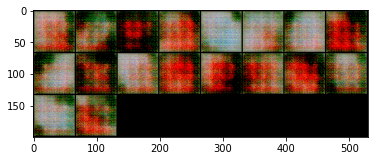

100%|██████████| 103/103 [00:23<00:00,  4.30it/s]


epoch: 1, lossD:0.9884233879449876, lossG:6.014858289829736,lossG_fake:3.552243885484714, lossG_real:2.4626143790275146 ,equality:1.0896295064571992


evaluate:144.45294189453125,kid_mean:0.08120407164096832, kid_std:0.03486711159348488,kid_:(tensor(0.0812), tensor(0.0349))


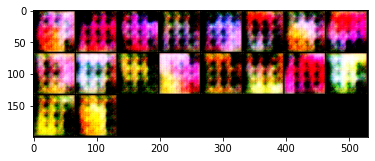

100%|██████████| 103/103 [00:22<00:00,  4.59it/s]


epoch: 2, lossD:1.12434951715099, lossG:5.689761911781089,lossG_fake:3.3907215537376776, lossG_real:2.299040355149982 ,equality:1.0916811985876955


evaluate:125.64273071289062,kid_mean:0.07039492577314377, kid_std:0.03620132431387901,kid_:(tensor(0.0704), tensor(0.0362))


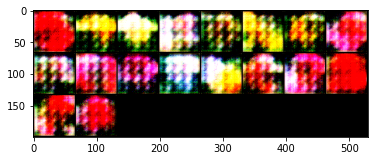

100%|██████████| 103/103 [00:22<00:00,  4.63it/s]


epoch: 3, lossD:0.9535993151005032, lossG:5.9161215569209125,lossG_fake:3.5200243644344, lossG_real:2.3960972127405187 ,equality:1.1239271516938811


evaluate:131.8329620361328,kid_mean:0.08556900173425674, kid_std:0.03839896246790886,kid_:(tensor(0.0856), tensor(0.0384))


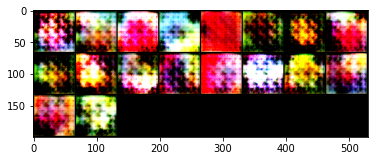

100%|██████████| 103/103 [00:22<00:00,  4.58it/s]


epoch: 4, lossD:0.9899410155502338, lossG:5.618385115873466,lossG_fake:3.2921988466410963, lossG_real:2.326186248978365 ,equality:0.9660125976627314


evaluate:126.82963562011719,kid_mean:0.08033633977174759, kid_std:0.039576560258865356,kid_:(tensor(0.0803), tensor(0.0396))


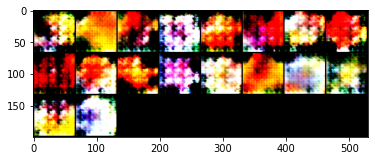

100%|██████████| 103/103 [00:22<00:00,  4.53it/s]


epoch: 5, lossD:1.0864500710107747, lossG:5.58415426791293,lossG_fake:3.378354268166625, lossG_real:2.205800006111849 ,equality:1.1725542620547764


evaluate:113.82476806640625,kid_mean:0.06481566280126572, kid_std:0.033109668642282486,kid_:(tensor(0.0648), tensor(0.0331))


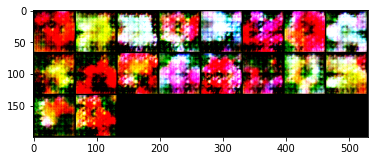

100%|██████████| 103/103 [00:22<00:00,  4.58it/s]


epoch: 6, lossD:1.0712693695304463, lossG:5.583220805936647,lossG_fake:3.3788328599003914, lossG_real:2.204387951244428 ,equality:1.1744449086559632


evaluate:111.51982879638672,kid_mean:0.06876886636018753, kid_std:0.038407690823078156,kid_:(tensor(0.0688), tensor(0.0384))


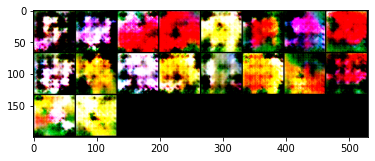

100%|██████████| 103/103 [00:22<00:00,  4.48it/s]


epoch: 7, lossD:1.0104826926027688, lossG:5.868744526094603,lossG_fake:3.532197793710579, lossG_real:2.3365467503232864 ,equality:1.1956510433872927


evaluate:119.13985443115234,kid_mean:0.06676149368286133, kid_std:0.0366828627884388,kid_:(tensor(0.0668), tensor(0.0367))


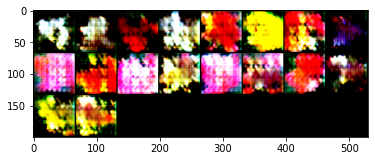

100%|██████████| 103/103 [00:22<00:00,  4.54it/s]


epoch: 8, lossD:0.9261210068915654, lossG:5.930505141471196,lossG_fake:3.5581322850532904, lossG_real:2.3723728598900213 ,equality:1.185759425163269


evaluate:122.10073852539062,kid_mean:0.07060729712247849, kid_std:0.03985666111111641,kid_:(tensor(0.0706), tensor(0.0399))


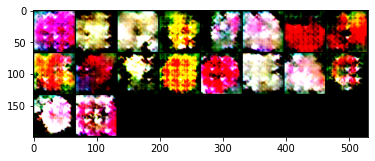

100%|██████████| 103/103 [00:22<00:00,  4.54it/s]


epoch: 9, lossD:0.9805193989022264, lossG:5.826946323357739,lossG_fake:3.495097712405677, lossG_real:2.3318486236831517 ,equality:1.1632490887225253


evaluate:118.08651733398438,kid_mean:0.0633004680275917, kid_std:0.03672536090016365,kid_:(tensor(0.0633), tensor(0.0367))


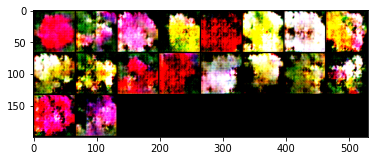

100%|██████████| 103/103 [00:24<00:00,  4.12it/s]


epoch: 10, lossD:1.0135490260656597, lossG:5.55969132728947,lossG_fake:3.281339187066532, lossG_real:2.2783521703146037 ,equality:1.0029870167519284


evaluate:118.5381851196289,kid_mean:0.06589716672897339, kid_std:0.03397008404135704,kid_:(tensor(0.0659), tensor(0.0340))


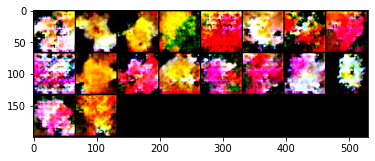

100%|██████████| 103/103 [00:23<00:00,  4.42it/s]


epoch: 11, lossD:0.9809707163028347, lossG:5.604302119282843,lossG_fake:3.314076456051428, lossG_real:2.2902256580232416 ,equality:1.0238507980281866


evaluate:119.47415161132812,kid_mean:0.07566884905099869, kid_std:0.03750183805823326,kid_:(tensor(0.0757), tensor(0.0375))


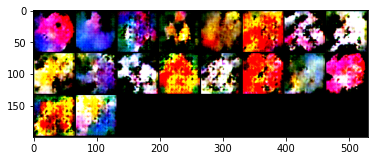

100%|██████████| 103/103 [00:23<00:00,  4.42it/s]


epoch: 12, lossD:1.044334477591283, lossG:5.490448002676362,lossG_fake:3.1748633998111613, lossG_real:2.315584591870169 ,equality:0.8592788079409921


evaluate:117.89212036132812,kid_mean:0.07532837986946106, kid_std:0.04249943420290947,kid_:(tensor(0.0753), tensor(0.0425))


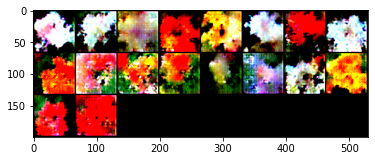

100%|██████████| 103/103 [00:23<00:00,  4.47it/s]


epoch: 13, lossD:0.9969349471689428, lossG:5.669254839999004,lossG_fake:3.3109295483931755, lossG_real:2.358325299707431 ,equality:0.9526042486857444


evaluate:116.67707824707031,kid_mean:0.07716245949268341, kid_std:0.03772203251719475,kid_:(tensor(0.0772), tensor(0.0377))


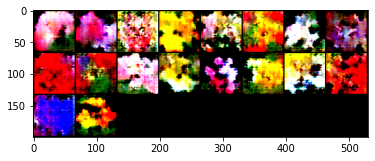

100%|██████████| 103/103 [00:24<00:00,  4.18it/s]


epoch: 14, lossD:0.9981267460920278, lossG:5.687735863102293,lossG_fake:3.353204270011013, lossG_real:2.3345315855683633 ,equality:1.0186726844426497


evaluate:104.34194946289062,kid_mean:0.0759342834353447, kid_std:0.039218515157699585,kid_:(tensor(0.0759), tensor(0.0392))


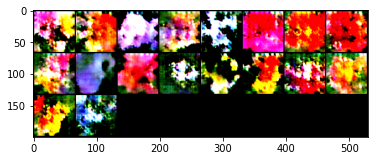

100%|██████████| 103/103 [00:23<00:00,  4.46it/s]


epoch: 15, lossD:0.9135936134069869, lossG:5.622275764502368,lossG_fake:3.1967351320877815, lossG_real:2.4255406358867018 ,equality:0.7711944962010797


evaluate:108.89518737792969,kid_mean:0.0775727927684784, kid_std:0.04099246487021446,kid_:(tensor(0.0776), tensor(0.0410))


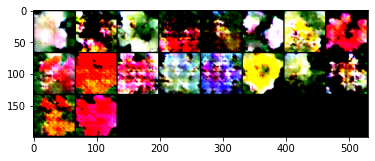

100%|██████████| 103/103 [00:22<00:00,  4.49it/s]


epoch: 16, lossD:0.8154792769007313, lossG:5.758752711768289,lossG_fake:3.2541000484262854, lossG_real:2.5046526465601135 ,equality:0.7494474018661719


evaluate:105.85355377197266,kid_mean:0.07857534289360046, kid_std:0.04387464374303818,kid_:(tensor(0.0786), tensor(0.0439))


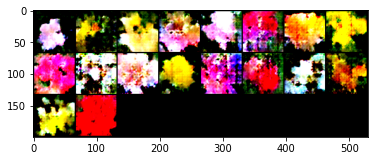

100%|██████████| 103/103 [00:23<00:00,  4.44it/s]


epoch: 17, lossD:0.79300425208888, lossG:5.908275280183958,lossG_fake:3.3745651800655625, lossG_real:2.533710085072564 ,equality:0.8408550949929987


evaluate:102.84893035888672,kid_mean:0.07292883098125458, kid_std:0.03794187679886818,kid_:(tensor(0.0729), tensor(0.0379))


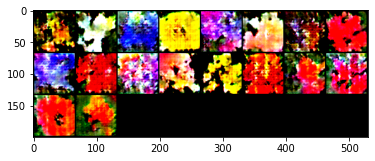

100%|██████████| 103/103 [00:23<00:00,  4.38it/s]


epoch: 18, lossD:0.822764630890587, lossG:5.867670401786137,lossG_fake:3.277658747237863, lossG_real:2.5900116545482748 ,equality:0.6876470926895881


evaluate:102.22180938720703,kid_mean:0.0655464455485344, kid_std:0.03591170534491539,kid_:(tensor(0.0655), tensor(0.0359))


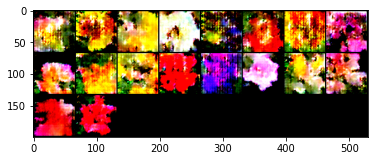

100%|██████████| 103/103 [00:23<00:00,  4.40it/s]


epoch: 19, lossD:0.8110958585172023, lossG:5.901352243516052,lossG_fake:3.298961242425789, lossG_real:2.60239099588209 ,equality:0.6965702465436991


evaluate:98.42606353759766,kid_mean:0.07805950939655304, kid_std:0.0460679717361927,kid_:(tensor(0.0781), tensor(0.0461))


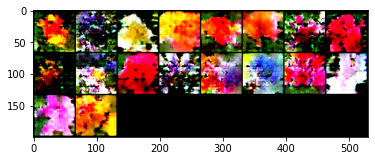

100%|██████████| 103/103 [00:23<00:00,  4.34it/s]


epoch: 20, lossD:0.7432261087651392, lossG:5.888285757268517,lossG_fake:3.318583689847039, lossG_real:2.5697020645280486 ,equality:0.7488816253189903


evaluate:97.65584564208984,kid_mean:0.06420867145061493, kid_std:0.03550295904278755,kid_:(tensor(0.0642), tensor(0.0355))


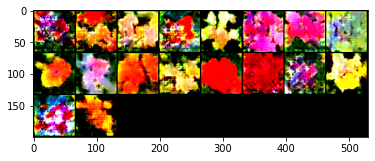

100%|██████████| 103/103 [00:23<00:00,  4.30it/s]


epoch: 21, lossD:0.7949029735280472, lossG:5.953578967492557,lossG_fake:3.2999533345398393, lossG_real:2.653625640475634 ,equality:0.6463276940642051


evaluate:97.84844207763672,kid_mean:0.07405134290456772, kid_std:0.04421636834740639,kid_:(tensor(0.0741), tensor(0.0442))


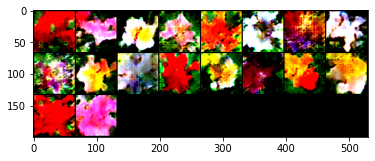

100%|██████████| 103/103 [00:23<00:00,  4.38it/s]


epoch: 22, lossD:0.795306851707616, lossG:5.881703071223879,lossG_fake:3.2529761675492073, lossG_real:2.6287269198778764 ,equality:0.6242492476713308


evaluate:96.65626525878906,kid_mean:0.06453118473291397, kid_std:0.039094649255275726,kid_:(tensor(0.0645), tensor(0.0391))


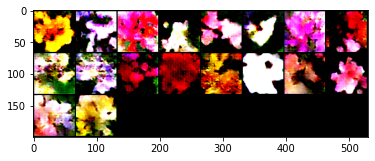

100%|██████████| 103/103 [00:23<00:00,  4.39it/s]


epoch: 23, lossD:0.7322881646381999, lossG:5.9718622605777485,lossG_fake:3.272799248834258, lossG_real:2.6990629689207353 ,equality:0.5737362799135228


evaluate:98.3908920288086,kid_mean:0.06864621490240097, kid_std:0.0393674299120903,kid_:(tensor(0.0686), tensor(0.0394))


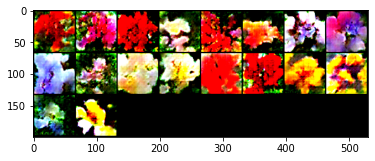

100%|██████████| 103/103 [00:23<00:00,  4.41it/s]


epoch: 24, lossD:0.7153521507833768, lossG:6.092649700572189,lossG_fake:3.362844299922869, lossG_real:2.7298054099082947 ,equality:0.6330388900145745


evaluate:96.83623504638672,kid_mean:0.07125966250896454, kid_std:0.03889186307787895,kid_:(tensor(0.0713), tensor(0.0389))


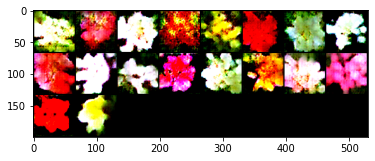

100%|██████████| 103/103 [00:24<00:00,  4.22it/s]


epoch: 25, lossD:0.6325054298905493, lossG:6.074703156369404,lossG_fake:3.349095105546192, lossG_real:2.7256080542953267 ,equality:0.6234870512508652


evaluate:98.42701721191406,kid_mean:0.06752900779247284, kid_std:0.03887781873345375,kid_:(tensor(0.0675), tensor(0.0389))


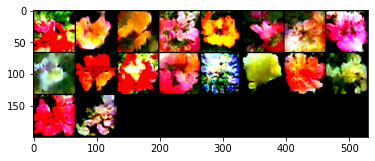

100%|██████████| 103/103 [00:23<00:00,  4.36it/s]


epoch: 26, lossD:0.6272230872396126, lossG:6.256623522749225,lossG_fake:3.401326851937377, lossG_real:2.855296699167455 ,equality:0.5460301527699221


evaluate:100.84107208251953,kid_mean:0.07689061015844345, kid_std:0.048221807926893234,kid_:(tensor(0.0769), tensor(0.0482))


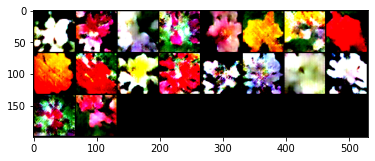

100%|██████████| 103/103 [00:23<00:00,  4.33it/s]


epoch: 27, lossD:0.6269991685030529, lossG:6.144365755099694,lossG_fake:3.30991479956988, lossG_real:2.8344509422200397 ,equality:0.4754638573498404


evaluate:100.0953369140625,kid_mean:0.0809929296374321, kid_std:0.041979942470788956,kid_:(tensor(0.0810), tensor(0.0420))


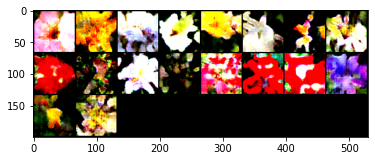

100%|██████████| 103/103 [00:23<00:00,  4.36it/s]


epoch: 28, lossD:0.5746944999521219, lossG:6.301974291940337,lossG_fake:3.4389253553834935, lossG_real:2.86304894407976 ,equality:0.5758764113037333


evaluate:100.60173797607422,kid_mean:0.0709460899233818, kid_std:0.03977794572710991,kid_:(tensor(0.0709), tensor(0.0398))


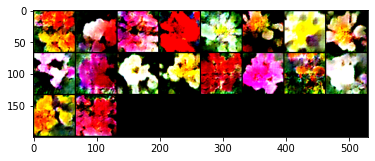

100%|██████████| 103/103 [00:25<00:00,  4.07it/s]


epoch: 29, lossD:0.6508810528852407, lossG:6.236592598331785,lossG_fake:3.405058235798067, lossG_real:2.83153435096 ,equality:0.573523884838067


evaluate:101.8218994140625,kid_mean:0.0737793892621994, kid_std:0.03992801532149315,kid_:(tensor(0.0738), tensor(0.0399))


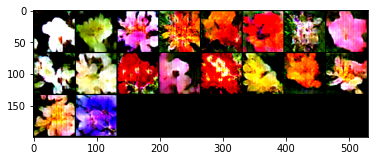

100%|██████████| 103/103 [00:23<00:00,  4.33it/s]


epoch: 30, lossD:0.6801016405948157, lossG:6.380829704617991,lossG_fake:3.480604762012519, lossG_real:2.9002249379759855 ,equality:0.5803798240365334


evaluate:100.59420013427734,kid_mean:0.07095910608768463, kid_std:0.036880478262901306,kid_:(tensor(0.0710), tensor(0.0369))


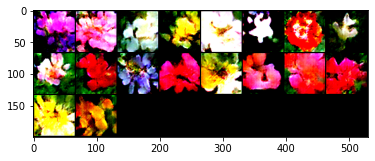

100%|██████████| 103/103 [00:23<00:00,  4.29it/s]


epoch: 31, lossD:0.5670958588858253, lossG:6.391983805350887,lossG_fake:3.502803966837022, lossG_real:2.8891798541383835 ,equality:0.6136241126986386


evaluate:99.70761108398438,kid_mean:0.0676247626543045, kid_std:0.040731411427259445,kid_:(tensor(0.0676), tensor(0.0407))


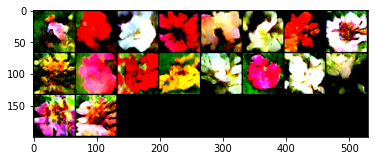

100%|██████████| 103/103 [00:24<00:00,  4.26it/s]


epoch: 32, lossD:0.6010008449620993, lossG:6.343337244200475,lossG_fake:3.355882924737282, lossG_real:2.987454320041879 ,equality:0.3684286046954033


evaluate:98.65479278564453,kid_mean:0.06969890743494034, kid_std:0.03402956575155258,kid_:(tensor(0.0697), tensor(0.0340))


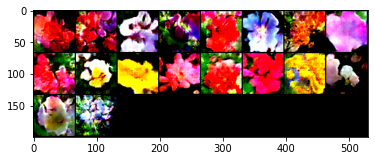

100%|██████████| 103/103 [00:24<00:00,  4.22it/s]


epoch: 33, lossD:0.6356569736906625, lossG:6.4177961349487305,lossG_fake:3.4989673848291045, lossG_real:2.918828767480202 ,equality:0.5801386173489025


evaluate:98.95516204833984,kid_mean:0.06857724487781525, kid_std:0.03750928118824959,kid_:(tensor(0.0686), tensor(0.0375))


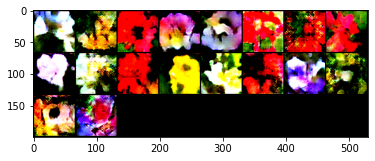

100%|██████████| 103/103 [00:24<00:00,  4.22it/s]


epoch: 34, lossD:0.6015895716484311, lossG:6.410666359281077,lossG_fake:3.502992010811, lossG_real:2.907674335738988 ,equality:0.5953176750720122


evaluate:100.67550659179688,kid_mean:0.07179062813520432, kid_std:0.03886272758245468,kid_:(tensor(0.0718), tensor(0.0389))


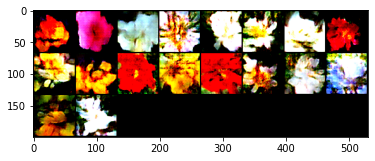

100%|██████████| 103/103 [00:24<00:00,  4.21it/s]


epoch: 35, lossD:0.5471586007082346, lossG:6.393188296012508,lossG_fake:3.4386663946133216, lossG_real:2.9545218799878095 ,equality:0.4841445146255121


evaluate:100.3936538696289,kid_mean:0.06568335741758347, kid_std:0.03912314400076866,kid_:(tensor(0.0657), tensor(0.0391))


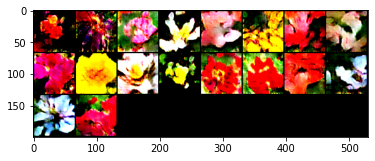

100%|██████████| 103/103 [00:24<00:00,  4.18it/s]


epoch: 36, lossD:0.5654087913340157, lossG:6.520295240346668,lossG_fake:3.5468754259128015, lossG_real:2.973419803438835 ,equality:0.5734556224739666


evaluate:101.38782501220703,kid_mean:0.06970594078302383, kid_std:0.037566352635622025,kid_:(tensor(0.0697), tensor(0.0376))


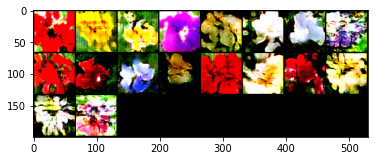

100%|██████████| 103/103 [00:24<00:00,  4.19it/s]


epoch: 37, lossD:0.5578071714460271, lossG:6.4968985770512555,lossG_fake:3.497944077241768, lossG_real:2.9989545090684615 ,equality:0.49898956817330653


evaluate:102.05868530273438,kid_mean:0.07491472363471985, kid_std:0.03815031424164772,kid_:(tensor(0.0749), tensor(0.0382))


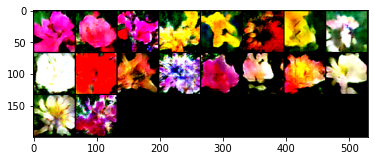

100%|██████████| 103/103 [00:24<00:00,  4.17it/s]


epoch: 38, lossD:0.5768869339841084, lossG:6.632100781190743,lossG_fake:3.642491926267309, lossG_real:2.989608831775999 ,equality:0.6528830944913104


evaluate:103.29810333251953,kid_mean:0.0741620883345604, kid_std:0.04149819537997246,kid_:(tensor(0.0742), tensor(0.0415))


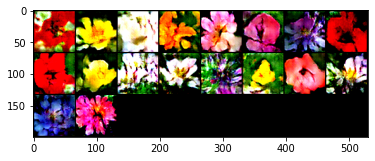

100%|██████████| 103/103 [00:24<00:00,  4.19it/s]


epoch: 39, lossD:0.5926164416867552, lossG:6.519472608288515,lossG_fake:3.493568241017536, lossG_real:3.0259043730578377 ,equality:0.4676638679596983


evaluate:103.12859344482422,kid_mean:0.07610313594341278, kid_std:0.038177330046892166,kid_:(tensor(0.0761), tensor(0.0382))


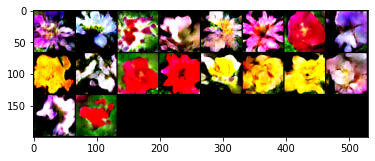

100%|██████████| 103/103 [00:24<00:00,  4.23it/s]


epoch: 40, lossD:0.5394918580801742, lossG:6.57557438415231,lossG_fake:3.50823430181707, lossG_real:3.0673400696041515 ,equality:0.44089423221291835


evaluate:103.44538116455078,kid_mean:0.07357176393270493, kid_std:0.04309874400496483,kid_:(tensor(0.0736), tensor(0.0431))


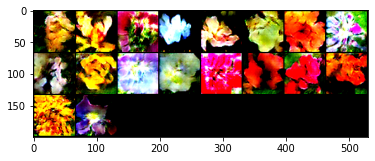

100%|██████████| 103/103 [00:24<00:00,  4.24it/s]


epoch: 41, lossD:0.5817508931877544, lossG:6.717018238549094,lossG_fake:3.6485135150187222, lossG_real:3.0685047212156276 ,equality:0.5800087938030947


evaluate:103.84626007080078,kid_mean:0.08011825382709503, kid_std:0.037180617451667786,kid_:(tensor(0.0801), tensor(0.0372))


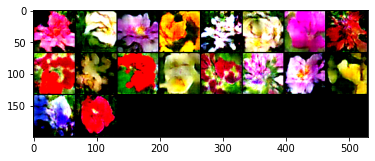

100%|██████████| 103/103 [00:24<00:00,  4.21it/s]


epoch: 42, lossD:0.4919390000619935, lossG:6.567896217975802,lossG_fake:3.4613424828908976, lossG_real:3.1065537455012495 ,equality:0.3547887373896481


evaluate:104.74251556396484,kid_mean:0.07995787262916565, kid_std:0.044464994221925735,kid_:(tensor(0.0800), tensor(0.0445))


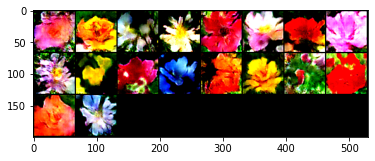

100%|██████████| 103/103 [00:24<00:00,  4.21it/s]


epoch: 43, lossD:0.44452541907435483, lossG:6.689515479560037,lossG_fake:3.5753461284544863, lossG_real:3.1141693545776663 ,equality:0.46117677387682


evaluate:104.25511169433594,kid_mean:0.08089720457792282, kid_std:0.04091648384928703,kid_:(tensor(0.0809), tensor(0.0409))


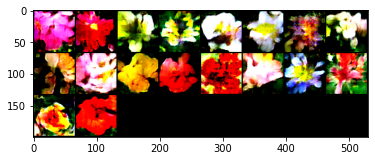

100%|██████████| 103/103 [00:24<00:00,  4.19it/s]


epoch: 44, lossD:0.4817367549985647, lossG:6.77226568888692,lossG_fake:3.5787140518716236, lossG_real:3.193551648010328 ,equality:0.38516240386129574


evaluate:104.54154205322266,kid_mean:0.0799742341041565, kid_std:0.04492394998669624,kid_:(tensor(0.0800), tensor(0.0449))


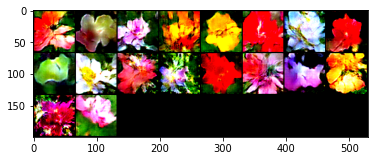

100%|██████████| 103/103 [00:24<00:00,  4.22it/s]


epoch: 45, lossD:0.4663634169304255, lossG:6.684090040262463,lossG_fake:3.5499182499728157, lossG_real:3.1341718030207364 ,equality:0.4157464469520793


evaluate:105.07199096679688,kid_mean:0.07833340764045715, kid_std:0.04139453172683716,kid_:(tensor(0.0783), tensor(0.0414))


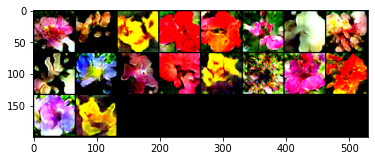

100%|██████████| 103/103 [00:24<00:00,  4.16it/s]


epoch: 46, lossD:0.48658740158798625, lossG:6.827212921624045,lossG_fake:3.632332196513426, lossG_real:3.1948807129582155 ,equality:0.43745148355521035


evaluate:104.6896743774414,kid_mean:0.07085807621479034, kid_std:0.039313700050115585,kid_:(tensor(0.0709), tensor(0.0393))


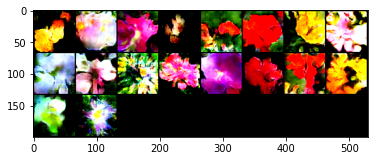

100%|██████████| 103/103 [00:25<00:00,  4.12it/s]


epoch: 47, lossD:0.5017418103853186, lossG:6.856115405999341,lossG_fake:3.6299388292923713, lossG_real:3.2261765952249175 ,equality:0.4037622340674538


evaluate:104.9302978515625,kid_mean:0.07698747515678406, kid_std:0.03907055780291557,kid_:(tensor(0.0770), tensor(0.0391))


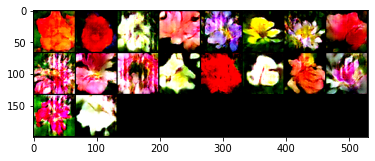

100%|██████████| 103/103 [00:25<00:00,  4.10it/s]


epoch: 48, lossD:0.4866042156314966, lossG:6.773232788715548,lossG_fake:3.5790823454995757, lossG_real:3.1941504461094015 ,equality:0.38493189939017425


evaluate:104.62613677978516,kid_mean:0.07598554342985153, kid_std:0.03955172374844551,kid_:(tensor(0.0760), tensor(0.0396))


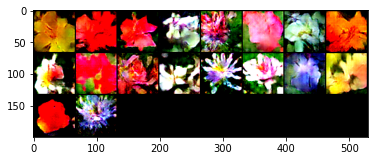

100%|██████████| 103/103 [00:24<00:00,  4.15it/s]


epoch: 49, lossD:0.49112941241524755, lossG:6.84005860449041,lossG_fake:3.5982084170128537, lossG_real:3.2418501984725876 ,equality:0.35635821854026606


evaluate:105.58094787597656,kid_mean:0.07122751325368881, kid_std:0.03843317925930023,kid_:(tensor(0.0712), tensor(0.0384))


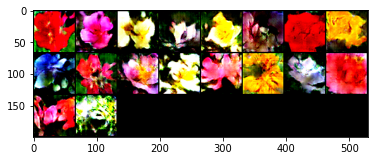

100%|██████████| 103/103 [00:25<00:00,  4.10it/s]


epoch: 50, lossD:0.3903550288630921, lossG:6.764814645341299,lossG_fake:3.519877507848647, lossG_real:3.2449371224468195 ,equality:0.2749403854018273


evaluate:106.18949890136719,kid_mean:0.07850055396556854, kid_std:0.03938005492091179,kid_:(tensor(0.0785), tensor(0.0394))


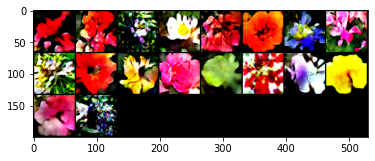

100%|██████████| 103/103 [00:25<00:00,  4.12it/s]


epoch: 51, lossD:0.3748994490981681, lossG:6.874826931259007,lossG_fake:3.6098322474840776, lossG_real:3.264994699978134 ,equality:0.34483754750594375


evaluate:106.76731872558594,kid_mean:0.08058176189661026, kid_std:0.0393940731883049,kid_:(tensor(0.0806), tensor(0.0394))


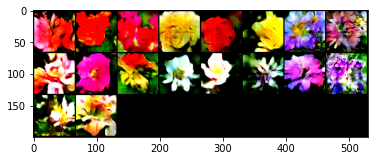

100%|██████████| 103/103 [00:25<00:00,  4.08it/s]


epoch: 52, lossD:0.46539918991547186, lossG:6.99242277052796,lossG_fake:3.6675812266405345, lossG_real:3.3248415618266876 ,equality:0.342739664813847


evaluate:106.79397583007812,kid_mean:0.07648561894893646, kid_std:0.038446299731731415,kid_:(tensor(0.0765), tensor(0.0384))


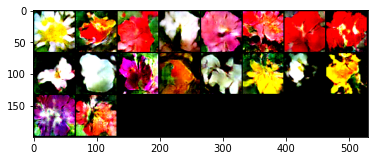

100%|██████████| 103/103 [00:25<00:00,  4.09it/s]


epoch: 53, lossD:0.4202769445707497, lossG:6.921215793461475,lossG_fake:3.6117680477864536, lossG_real:3.3094477202128436 ,equality:0.30232032757360994


evaluate:107.19097900390625,kid_mean:0.0782063752412796, kid_std:0.046362053602933884,kid_:(tensor(0.0782), tensor(0.0464))


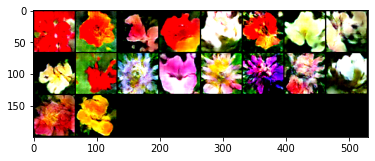

100%|██████████| 103/103 [00:25<00:00,  4.08it/s]


epoch: 54, lossD:0.4443607213861734, lossG:7.052763735206382,lossG_fake:3.7220130302373646, lossG_real:3.3307507165427346 ,equality:0.39126231369463005


evaluate:108.21766662597656,kid_mean:0.0700840950012207, kid_std:0.040186282247304916,kid_:(tensor(0.0701), tensor(0.0402))


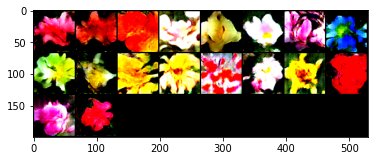

100%|██████████| 103/103 [00:25<00:00,  4.09it/s]


epoch: 55, lossD:0.36509338665066415, lossG:6.92314549788688,lossG_fake:3.6197533005649603, lossG_real:3.303392214682496 ,equality:0.31636108588246437


evaluate:108.09185791015625,kid_mean:0.07517775893211365, kid_std:0.03875160589814186,kid_:(tensor(0.0752), tensor(0.0388))


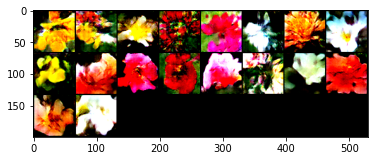

100%|██████████| 103/103 [00:25<00:00,  4.10it/s]


epoch: 56, lossD:0.42614565645028085, lossG:7.071449002015938,lossG_fake:3.681985278731411, lossG_real:3.3894637383303596 ,equality:0.29252154040105127


evaluate:108.5553207397461,kid_mean:0.08108661323785782, kid_std:0.044346246868371964,kid_:(tensor(0.0811), tensor(0.0443))


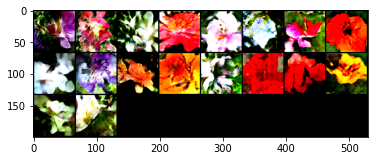

100%|██████████| 103/103 [00:25<00:00,  4.08it/s]


epoch: 57, lossD:0.35171089118834836, lossG:7.029596587986622,lossG_fake:3.6668177125523393, lossG_real:3.362778867332681 ,equality:0.3040388452196585


evaluate:108.53334045410156,kid_mean:0.07691802084445953, kid_std:0.04351259768009186,kid_:(tensor(0.0769), tensor(0.0435))


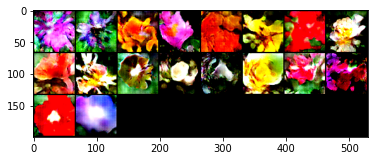

100%|██████████| 103/103 [00:25<00:00,  4.10it/s]


epoch: 58, lossD:0.3846913672694304, lossG:7.14397971606949,lossG_fake:3.7160568150501807, lossG_real:3.4279229085422256 ,equality:0.2881339065079551


evaluate:107.65599822998047,kid_mean:0.07466820627450943, kid_std:0.03898897022008896,kid_:(tensor(0.0747), tensor(0.0390))


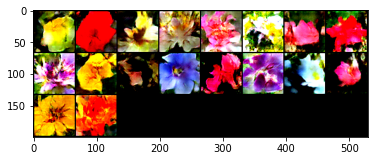

100%|██████████| 103/103 [00:25<00:00,  4.07it/s]


epoch: 59, lossD:0.40947722404905895, lossG:7.2748942375183105,lossG_fake:3.8176605247178124, lossG_real:3.457233705566925 ,equality:0.3604268191508875


evaluate:107.81529235839844,kid_mean:0.07804309576749802, kid_std:0.040950383991003036,kid_:(tensor(0.0780), tensor(0.0410))


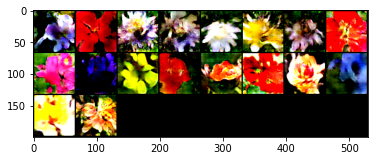

100%|██████████| 103/103 [00:25<00:00,  4.09it/s]


epoch: 60, lossD:0.28574718491545004, lossG:7.11981997906583,lossG_fake:3.666687827665829, lossG_real:3.453132156029488 ,equality:0.2135556716363407


evaluate:107.57366180419922,kid_mean:0.08169698715209961, kid_std:0.036825161427259445,kid_:(tensor(0.0817), tensor(0.0368))


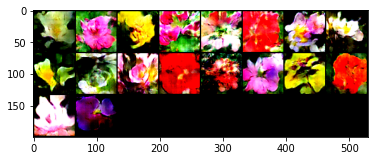

100%|██████████| 103/103 [00:25<00:00,  4.09it/s]


epoch: 61, lossD:0.26068844380381617, lossG:7.230240664435822,lossG_fake:3.711777533142312, lossG_real:3.518463148654086 ,equality:0.19331438448822613


evaluate:107.781494140625,kid_mean:0.07639369368553162, kid_std:0.040130119770765305,kid_:(tensor(0.0764), tensor(0.0401))


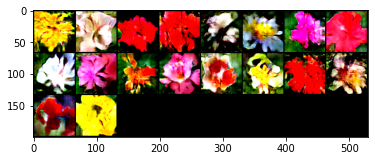

100%|██████████| 103/103 [00:25<00:00,  4.07it/s]


epoch: 62, lossD:0.3060777713951555, lossG:7.333874008030567,lossG_fake:3.7956278104226566, lossG_real:3.5382461906636804 ,equality:0.2573816197589762


evaluate:108.11458587646484,kid_mean:0.0719166100025177, kid_std:0.04294206202030182,kid_:(tensor(0.0719), tensor(0.0429))


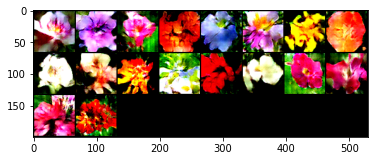

100%|██████████| 103/103 [00:25<00:00,  4.09it/s]


epoch: 63, lossD:0.3156719555698552, lossG:7.352458240916428,lossG_fake:3.82573291051735, lossG_real:3.526725302622156 ,equality:0.29900760789519376


evaluate:108.27717590332031,kid_mean:0.08265195786952972, kid_std:0.04001813009381294,kid_:(tensor(0.0827), tensor(0.0400))


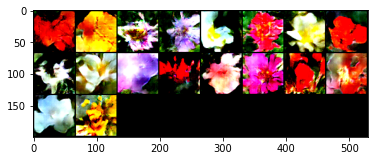

100%|██████████| 103/103 [00:25<00:00,  4.07it/s]


epoch: 64, lossD:0.347206448575536, lossG:7.450085621435665,lossG_fake:3.908645870616135, lossG_real:3.541439761235876 ,equality:0.367206109380259


evaluate:108.86366271972656,kid_mean:0.08350636810064316, kid_std:0.04567360132932663,kid_:(tensor(0.0835), tensor(0.0457))


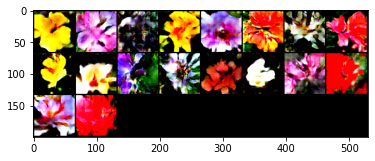

100%|██████████| 103/103 [00:25<00:00,  4.02it/s]


epoch: 65, lossD:0.3056052847973351, lossG:7.346554932085056,lossG_fake:3.796704902232272, lossG_real:3.5498500310101555 ,equality:0.24685487122211658


evaluate:108.48837280273438,kid_mean:0.08687195181846619, kid_std:0.05441572517156601,kid_:(tensor(0.0869), tensor(0.0544))


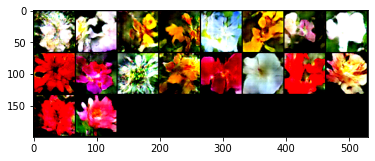

100%|██████████| 103/103 [00:25<00:00,  3.99it/s]


epoch: 66, lossD:0.24594271074510315, lossG:7.274089790084987,lossG_fake:3.77181648629383, lossG_real:3.5022733385123095 ,equality:0.26954314778152044


evaluate:108.41088104248047,kid_mean:0.07718022167682648, kid_std:0.039598528295755386,kid_:(tensor(0.0772), tensor(0.0396))


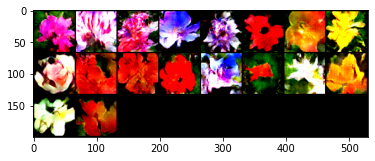

100%|██████████| 103/103 [00:26<00:00,  3.96it/s]


epoch: 67, lossD:0.2805335302520724, lossG:7.503040943330931,lossG_fake:3.86029628700423, lossG_real:3.642744689311796 ,equality:0.21755159769243404


evaluate:108.96908569335938,kid_mean:0.07520714402198792, kid_std:0.04358683526515961,kid_:(tensor(0.0752), tensor(0.0436))


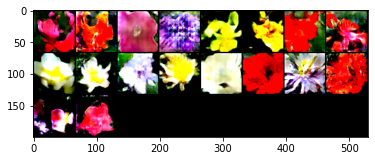

100%|██████████| 103/103 [00:26<00:00,  3.96it/s]


epoch: 68, lossD:0.31544364871258296, lossG:7.60886026123195,lossG_fake:3.943033927852668, lossG_real:3.665826305602361 ,equality:0.27720762225030704


evaluate:108.80471801757812,kid_mean:0.07999832928180695, kid_std:0.03881324082612991,kid_:(tensor(0.0800), tensor(0.0388))


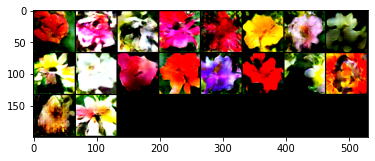

100%|██████████| 103/103 [00:26<00:00,  3.94it/s]


epoch: 69, lossD:0.24232047132569032, lossG:7.560242277904622,lossG_fake:3.8609350803986335, lossG_real:3.6993071980846737 ,equality:0.16162788231395986


evaluate:109.77058410644531,kid_mean:0.07563500851392746, kid_std:0.035301633179187775,kid_:(tensor(0.0756), tensor(0.0353))


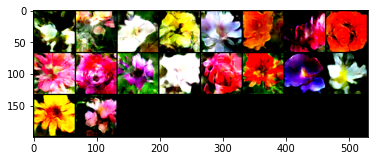

100%|██████████| 103/103 [00:26<00:00,  3.89it/s]


epoch: 70, lossD:0.2868438485322647, lossG:7.6064540622303785,lossG_fake:3.9434245222980535, lossG_real:3.6630295202570053 ,equality:0.28039500204104817


evaluate:108.6141128540039,kid_mean:0.07576391845941544, kid_std:0.038577716797590256,kid_:(tensor(0.0758), tensor(0.0386))


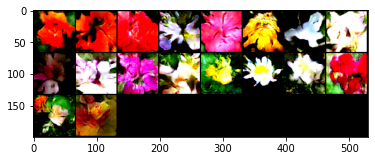

100%|██████████| 103/103 [00:26<00:00,  3.90it/s]


epoch: 71, lossD:0.3104203744312224, lossG:7.579106344760043,lossG_fake:3.913425485196623, lossG_real:3.665680841334815 ,equality:0.24774464386180783


evaluate:108.14359283447266,kid_mean:0.07947895675897598, kid_std:0.041698917746543884,kid_:(tensor(0.0795), tensor(0.0417))


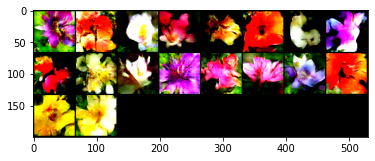

100%|██████████| 103/103 [00:26<00:00,  3.91it/s]


epoch: 72, lossD:0.2243130182467618, lossG:7.6532167647648786,lossG_fake:3.9534001153649636, lossG_real:3.699816666760491 ,equality:0.25358344860447257


evaluate:107.66014099121094,kid_mean:0.07508204877376556, kid_std:0.04210086166858673,kid_:(tensor(0.0751), tensor(0.0421))


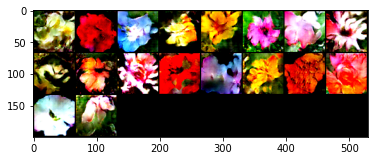

100%|██████████| 103/103 [00:26<00:00,  3.95it/s]


epoch: 73, lossD:0.22930854640322404, lossG:7.690101989264627,lossG_fake:3.951984447182961, lossG_real:3.7381175316653206 ,equality:0.21386691551764025


evaluate:107.70838165283203,kid_mean:0.07680554687976837, kid_std:0.04167080298066139,kid_:(tensor(0.0768), tensor(0.0417))


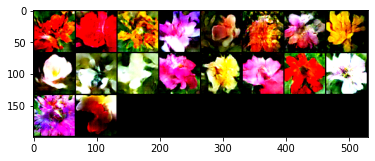

100%|██████████| 103/103 [00:26<00:00,  3.88it/s]


epoch: 74, lossD:0.267653627610467, lossG:7.821659416828341,lossG_fake:4.029577849559414, lossG_real:3.7920816181932837 ,equality:0.23749623136612996


evaluate:107.66829681396484,kid_mean:0.07620652765035629, kid_std:0.04242066293954849,kid_:(tensor(0.0762), tensor(0.0424))


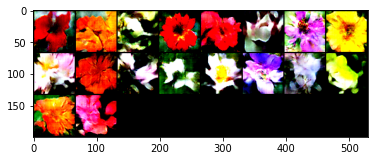

In [44]:
lossesD = []
lossesG = []

raw_lossesD = []
raw_lossesG = []
lossesG_fake = []
lossesG_real = []

equality = 0.0
sum_equality = 0.0
d_equality = []

relu = torch.nn.ReLU()

fid_ = []
kid_mean_ = []
kid_std_ = []
kid_score = []
for epoch in range(opt.n_epoch):
    running_lossD = 0.0 #損失関数初期化
    running_lossG = 0.0
    lossG_fake_running = 0.0
    lossG_real_running = 0.0

    #sum_equality += equality 
    equality = 0.0
   # for i , (real_imgs, _) in enumerate(tqdm.tqdm(dataloader, position = 0)):#celebA
    for i , real_imgs in enumerate(tqdm.tqdm(dataloader, position = 0)):#flower
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size()[0]
        noise = torch.randn(batch_size, opt.z_dim, 1, 1).to(device)

        #train discriminator

        netD.zero_grad()
        output_real = netD(real_imgs)

        #lossD_real = criterion(output, labels_real)
        lossD_real = torch.mean(relu(1.0 - output_real))


        fake_imgs = netG(noise)##not train  output_fake_d
        output_fake_d = netD(fake_imgs.detach())#not train  output_fake_d

        #lossD_fake = criterion(output, labels_fake)
        lossD_fake = torch.mean(relu(1.0 + output_fake_d))
        

        lossD = lossD_real + lossD_fake
        #lossD = torch.mean(torch.log(torch.sigmoid(output_real)))- torch.mean(torch.log(torch.sigmoid(output_fake_d)))  #not train  output_fake_d
        lossD.backward()
        optimizerD.step()
        
        #train generator
        
        netG.zero_grad()#勾配初期

        output_fake_g = netD(fake_imgs)#train  output_fake_g
        output_real = netD(real_imgs)

        lossG_fake = torch.mean(relu(1.0 - output_fake_g))
        lossG_real = torch.mean(relu(1.0 + output_real))
        #lossG =  torch.mean(torch.log(torch.sigmoid(output_fake_g - output_real))) #- torch.mean(torch.log(torch.sigmoid(output_real)))#train  output_fake_g
        lossG =    lossG_real + lossG_fake    


        lossG.backward()
        optimizerG.step()
        
        # save loss
        
        running_lossD += lossD.item()
        running_lossG += lossG.item()
        
        raw_lossesD.append(lossD.item())
        raw_lossesG.append(lossG.item())

        lossG_fake_running += lossG_fake.item()
        lossG_real_running += lossG_real.item()


        
    running_lossD /=len(dataloader)
    running_lossG /=len(dataloader)

    lossG_fake_running /= len(dataloader)
    lossG_real_running /= len(dataloader)
#equality
    equality = ( lossG_fake_running - lossG_real_running  )
    d_equality.append(equality)


    print("epoch: {}, lossD:{}, lossG:{},lossG_fake:{}, lossG_real:{} ,equality:{}".format(epoch, running_lossD, running_lossG,lossG_fake_running,lossG_real_running,equality))#-->,lossG_fake:{}, lossG_real:{},lossG_fake_running,lossG_real_running
    lossesD.append(running_lossD)
    lossesG.append(running_lossG)

    lossesG_fake.append(lossG_fake_running)
    lossesG_real.append(lossG_real_running)

     #evaluate GAN
    fake_imgs_1 = fake_imgs.detach()
    real_imgs_1 = real_imgs.to(dtype=torch.uint8).cpu()
    fake_imgs_1 = fake_imgs_1.to(dtype=torch.uint8).cpu()
    fid.update(real_imgs_1, real=True)
    fid.update(fake_imgs_1, real=False)
    eval = fid.compute()

    kid.update(real_imgs_1, real=True)
    kid.update(fake_imgs_1, real=False)
    kid_ = kid.compute()
    kid_mean, kid_std = kid.compute()

    
  
    print("evaluate:{},kid_mean:{}, kid_std:{},kid_:{}".format(eval, kid_mean, kid_std, kid_))
    fid_.append(eval)
    kid_mean_.append(kid_mean)
    kid_std_.append(kid_std)
    kid_score.append(kid_)
    #show fake image
    grid_imgs = vutils.make_grid(fake_imgs[:24].detach()+0.5)
    grid_imgs_arr = grid_imgs.cpu().numpy()
    plt.imshow(np.transpose(grid_imgs_arr, (1,2,0)))
    plt.show()

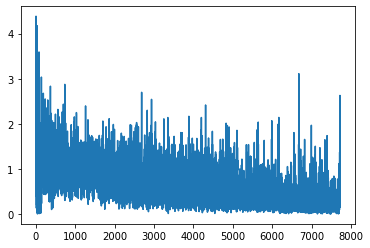

In [45]:
plt.plot(raw_lossesD)

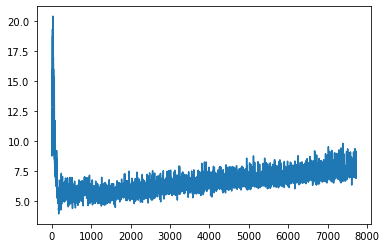

In [46]:
plt.plot(raw_lossesG)

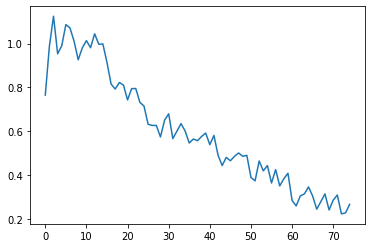

In [47]:
plt.plot(lossesD)

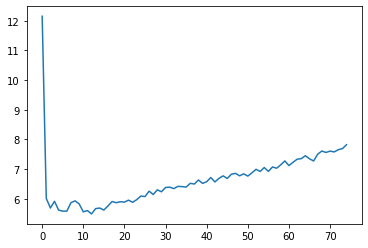

In [48]:
plt.plot(lossesG)

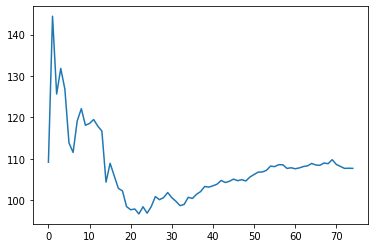

In [49]:
plt.plot(fid_)

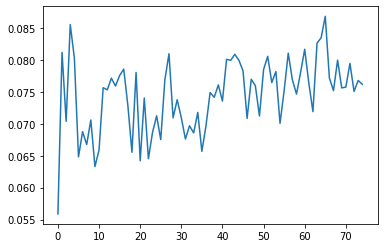

In [50]:
plt.plot(kid_mean_)

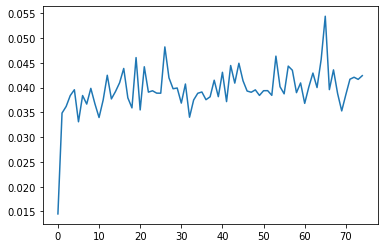

In [51]:
plt.plot(kid_std_)

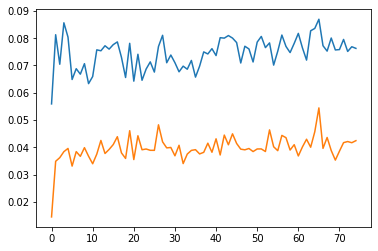

In [52]:
plt.plot(kid_score)

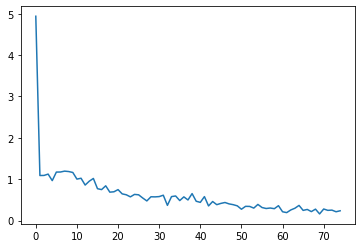

In [53]:
plt.plot(d_equality)

In [54]:

real_imgs = real_imgs.to(dtype=torch.uint8).cpu()
fake_imgs = fake_imgs.to(dtype=torch.uint8).cpu()
fid.update(real_imgs, real=True)
fid.update(fake_imgs, real=False)
fid.compute()

kid.update(real_imgs, real=True)
kid.update(fake_imgs, real=False)
kid.compute()

(tensor(0.0794), tensor(0.0425))